In [1]:
"Option pricing models"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import sparse
from scipy.fft import fft
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import RectBivariateSpline
import scipy.linalg as linalg
import scipy.optimize as optimize

import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- Option Pricing Calculations ---

# --- 1. Define Heston Model Parameters and Option Details ---

# Model parameters
v0 = 0.04       # Initial variance (20% volatility)
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation between asset and variance (typically negative)
#Market parameters
S0 = 100.0      # Initial stock price
K = 80.0        # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.03        # Risk-free rate (3%)
q = 0.02        # Dividend yield (2%)


In [3]:
# --- 2. Define the Heston Characteristic Function ---

def char_func_heston(u, T, r, v0, theta, kappa, sigma, rho, stable=True):
    
    if stable==True:
        """
        Computes the Heston characteristic function using a numerically stable formulation
        """
        # This version uses hyperbolic functions for improved numerical stability
        # Numerically stable calculation of C and D

        i = 1j  # Imaginary unit
        
        # Common terms
        beta = kappa - rho * sigma * i * u
        d = np.sqrt(beta**2 + sigma**2 * (u**2 + i * u))
        d_t_half = d * T / 2.0
        
        # Handle the case where d_t_half is very small to avoid division by zero in sinh
        # For small x, sinh(x) approx x and cosh(x) approx 1
        # This prevents NaN values for u=0
        small_d_mask = np.abs(d_t_half) < 1e-10
        
        # Calculate sinh and cosh safely
        sinh_d_tau_half = np.sinh(d_t_half)
        cosh_d_tau_half = np.cosh(d_t_half)
        # Note: coth(x) = 1/tanh(x) = cosh(x)/sinh(x)
        """
        # Avoid numerical issues when d*T is very small
        if np.abs(d_half_T) < 1e-8:
            # Use Taylor expansion for small arguments
            sinh_d_tau_half = d_t_half * (1 + (d_t_half)**2 / 6)
            cosh_d_tau_half = 1 + (d_t_half)**2 / 2
        else:
            sinh_d_tau_half = np.sinh(d_t_half)
            cosh_d_tau_half = np.cosh(d_t_half)
        """

        # D term
        # When d is small, d*coth(d*T/2) -> 2/T
        D_val = -(u**2 + i * u) / (beta + d * cosh_d_tau_half / sinh_d_tau_half)
        D_val[small_d_mask] = -(u[small_d_mask]**2 + i * u[small_d_mask]) / (beta[small_d_mask] + 2.0/T)

        # C term
        # When d is small, the log term simplifies
        log_term = cosh_d_tau_half + (beta / d) * sinh_d_tau_half
        log_term[small_d_mask] = 1.0 # Log(1)=0, so the term vanishes
        
        C_val = (kappa * theta / sigma**2) * (beta * T - 2 * np.log(log_term))

        # The characteristic function
        phi = np.exp(C_val + D_val * v0 + i * u * (np.log(S0) + r * T))
    
    else:
        """
        Computes the Heston characteristic function
        """
        i = 1j  # Imaginary unit
        
        # Calculate d and g
        beta = kappa - rho * sigma * i * u
        d = np.sqrt((rho * sigma * i * u - kappa)**2 + sigma**2 * (u**2 + i * u))
        g = (beta - d) / (beta + d)

        # Calculate C and D
        C = ((kappa * theta / sigma**2) * ((beta - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))))
        D = ((beta - d) / sigma**2) * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))

        # The characteristic function
        phi = np.exp(C + D * v0 + (i * u) * (r * T + np.log(S0)))
        
    return phi

# --- 3. Implement the FFT-based Pricing Method ---
# This function calls the stable characteristic function

def price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho, N = 2**12, eta = 0.25, alpha = 1.5, simpson=True):
    """
    Prices European call options using the Heston model and FFT.
    Returns a range of strikes and their corresponding call prices.

    K: Strike price
    T: Time to maturity
    N: Number of points for FFT
    alpha: Damping parameter
    # FFT parameters
    N = 2**12             # Number of points, should be a power of 2
    alpha = 1.5           # Dampening factor for integrability
    eta = 0.25            # Grid spacing in Fourier domain
    """

    i = 1j  # Imaginary unit
    lambda_ = (2 * np.pi) / (N * eta)  # Step-size in log strike space

    # Grids
    v = np.arange(N) * eta # Integration points
    #k = np.log(S0) - (N / 2) * lambda_ + np.arange(N) * lambda_  # Strike price range
    k = -(N * lambda_ / 2) + lambda_ * np.arange(N)
    strikes = np.exp(k)
    
    # Calculate the Fourier transform of the call price
    u_for_psi = v - (alpha + 1) * i
    numerator = np.exp(-r * T) * char_func_heston(u_for_psi, T, r, v0, theta, kappa, sigma, rho)
    denominator = (alpha + i * v) * (alpha + 1 + i * v)
    psi = numerator / denominator # Damping function

    if simpson == True:
        # Simpson's rule weights
        # Apply Simpson's rule weighting for better accuracy
        simpson_weights = (eta / 3) * (3 + (-1)**(np.arange(N) + 1) - (np.arange(N) == 0))
        fft_input = np.exp(i * v * (N / 2) * lambda_) * psi * simpson_weights
            
    else:
        eta = np.full(N, eta)
        fft_input = np.exp(i * v * (N / 2) * lambda_) * psi * eta

    # FFT
    call_prices_fft = np.fft.fft(fft_input)
    
    call_prices = np.exp(-alpha * k) / np.pi * np.real(call_prices_fft)
    #call_prices = np.exp(-alpha * k) * np.real(call_prices_fft) / np.pi
    
    return strikes, call_prices


Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.03, T=1.0

Price for an at-the-money (K=100) call option: 9.2434


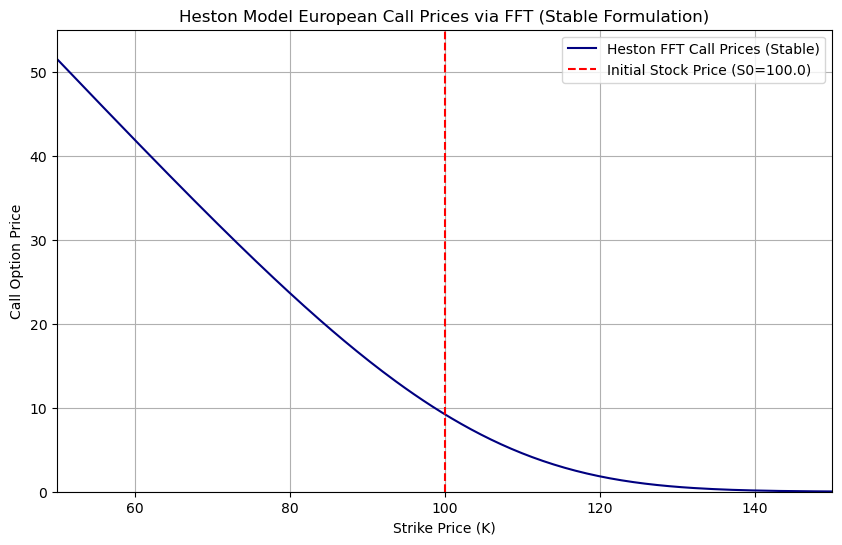

In [4]:
# --- 4. Price the option and visualize the results ---

if __name__ == '__main__':
    # Get the prices for a range of strikes using the stable method
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
    
    # Find the price for an at-the-money strike (K=100)
    atm_strike = 100
    atm_price = np.interp(atm_strike, strikes, call_prices)
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Price for an at-the-money (K={atm_strike}) call option: {atm_price:.4f}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, call_prices, label='Heston FFT Call Prices (Stable)', color='navy')
    plt.axvline(x=S0, color='r', linestyle='--', label=f'Initial Stock Price (S0={S0})')
    plt.xlabel('Strike Price (K)')
    plt.ylabel('Call Option Price')
    plt.title('Heston Model European Call Prices via FFT (Stable Formulation)')
    plt.grid(True)
    plt.legend()
    plt.xlim([50, 150])
    plt.ylim([0, 55])
    plt.show()

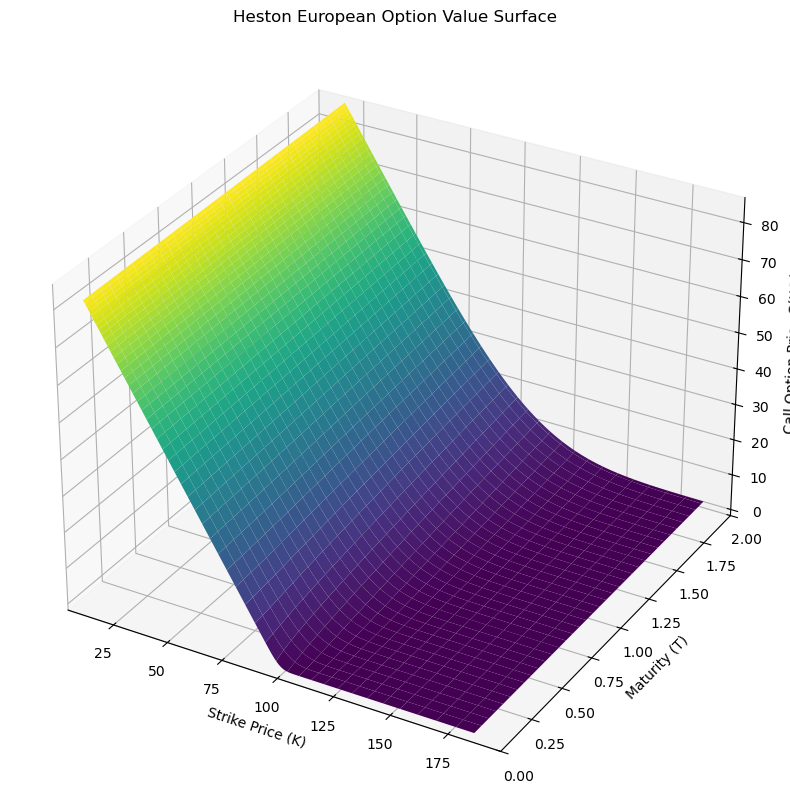

In [5]:
# --- 5. Visualize the Option Value Surface ---

maturities = np.linspace((1/52), 2.0, 104)
prices = np.zeros((len(maturities), 2**12))

for n, T in enumerate(maturities):
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
    prices[n, :] = np.array(call_prices)

prices = prices[:, 2500:2900]
strikes = strikes[2500:2900]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
#strikes, maturities = np.meshgrid(strikes, maturities, indexing='ij')
strikes, maturities = np.meshgrid(strikes, maturities)

ax.plot_surface(strikes, maturities, prices, cmap='viridis')
ax.set_title("Heston European Option Value Surface")
ax.set_xlabel("Strike Price (K)")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Call Option Price C(K,T)")
#ax.set_xlim(25, 150)
ax.set_ylim(0, 2)
#ax.set_zlim(0, 100)
plt.show()


In [6]:
# --- Model Calibration ---

# --- 1. Create Synthetic Market Data ---

# These are the "true" parameters we are trying to find
true_params = {'v0': 0.03, 'theta': 0.03, 'kappa': 1.5, 'sigma': 0.25, 'rho': -0.6}
S0 = 100.0
r = 0.03

# Define market instruments (strikes and maturities)
market_maturities = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0]
market_strikes = [60, 70, 80, 90, 100, 110, 120, 130, 140]

market_data = []
for T in market_maturities:
    # Generate clean prices with the true parameters
    strikes, call_prices = price_call_heston_fft(S0, T, r, true_params['v0'], true_params['theta'], 
                                                 true_params['kappa'], true_params['sigma'], true_params['rho'])
    # Interpolate to get prices for the specific strikes we need
    interp_func = interp1d(strikes, call_prices, kind='cubic', fill_value="extrapolate")
    clean_prices = interp_func(market_strikes)

    # Add some noise to simulate a real market
    noisy_prices = clean_prices + np.random.normal(0, 0.1, len(clean_prices))
    for K, price in zip(market_strikes, noisy_prices):
        market_data.append({'Maturity': T, 'Strike': K, 'Price': price})

market_df = pd.DataFrame(market_data)
print("--- Synthetic Market Data ---")
print(market_df)
print("\n")

--- Synthetic Market Data ---
    Maturity  Strike      Price
0       0.25      60  40.381965
1       0.25      70  30.368083
2       0.25      80  20.693651
3       0.25      90  11.271735
4       0.25     100   3.824715
..       ...     ...        ...
58      2.00     100  12.546809
59      2.00     110   7.677347
60      2.00     120   4.168472
61      2.00     130   1.890283
62      2.00     140   0.885191

[63 rows x 3 columns]




In [7]:
# --- 2. Find Optimal Parameter Starting Point ---

params1 = (0.1, 0.01, 0.5, 0.05, -0.3)
params2 = (0.01, 0.1, 4.0, 0.5, -0.9)

iArray = []
rmseArray = []
rmseMin = 1e10

def rmse_ht(params, market_df=market_df, S0=S0, r=r):
    total_error = 0.0
    v0, theta, kappa, sigma, rho = params

    for index, option in market_df.iterrows():
        T = option['Maturity']
        K = option['Strike']
        market_price = option['Price']

        # Calculate model prices for this maturity
        model_strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
        model_price = np.interp(K, model_strikes, call_prices)
        
        # Add squared error to the total
        total_error += (model_price - market_price)**2
    
    # We want to minimize the mean squared error
    mse = total_error / len(market_df)
    rmse = np.sqrt(mse)
    
    return rmse

for i in np.arange(0, 1.05, 0.05):

    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)

    rmse = rmse_ht(params, market_df, S0, r) 
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


1.6789879808765547
[ 0.0685  0.0415  1.725   0.2075 -0.51  ]


In [8]:
# --- 3. Define the Objective Function for Calibration ---

"""
BFGS is a powerful gradient-based method, however the Heston objective function can be challenging.
It's often non-convex and may have many local minima.
Alternative: Nelder-Mead (Simplex Method)
A gradient-free method (doesn't require derivatives). It maintains a geometric shape called a simplex 
in the parameter space and iteratively reflects, expands, or contracts it to "crawl" towards a minimum.
"""

def objective_function(params, S0, r, market_df):
    v0, theta, kappa, sigma, rho = params

    # Enforce bounds manually since Nelder-Mead doesn't support them.
    if not (1e-4 < v0 < 0.5 and 1e-4 < theta < 0.5 and 0.1 < kappa < 5.0 and 0.05 < sigma < 1.0 and -0.99 < rho < 0.99):
        return 1e12 # Return a large penalty

    # Add a penalty for violating the Feller condition (2*kappa*theta > sigma**2)
    # feller_penalty = max(0, sigma**2 - 2 * kappa * theta) * 1e4
    
    total_error = 0.0
    
    # Group by maturity for efficiency
    #for T, group in market_df.groupby('Maturity'):
        #strikes = group['Strike'].values
        #market_prices = group['Price'].values
        
    for index, option in market_df.iterrows():
        T = option['Maturity']
        K = option['Strike']
        market_price = option['Price']

        # Calculate model prices for this maturity
        model_strikes, call_prices = price_call_heston_fft(S0, T, r,  v0, theta, kappa, sigma, rho)
        model_price = np.interp(K, model_strikes, call_prices)
        # Interpolate to get prices for the specific strikes we need
        #interp_func = interp1d(model_strikes, call_prices, kind='cubic', fill_value="extrapolate")
        #model_prices = interp_func(model_strikes)
        #print(f"T={T}, K={K}, Market Price={market_price:.4f}, Model Price={model_price:.4f}")

        # Add squared error to the total
        total_error += np.sum((model_price - market_price)**2)
    
    # We want to minimize the mean squared error
    mse = total_error / len(market_df)
    rmse = np.sqrt(mse)
    # rmse = np.sqrt(mse + feller_penalty)
    print(f"Params: [v0:{v0:.4f}, θ:{theta:.4f}, κ:{kappa:.4f}, σ:{sigma:.4f}, ρ:{rho:.4f}] | MSE: {mse:.6f}, | RMSE: {rmse:.6f}")
    return rmse

# --- 4. Run the Optimization ---

# Initial guess for the parameters
#initial_guess = [0.06, 0.05, 1.5, 0.4, -0.5]
#[ 0.0685  0.0415  1.725  0.2075  -0.51  ]
initial_guess = optimParams

# --- Run the BFGS Optimization ---

# Parameter bounds to ensure they are realistic
# (v0, theta, kappa, sigma > 0) and (-1 < rho < 1)
bounds = [(1e-4, 0.5), (1e-4, 0.5), (0.1, 5.0), (0.05, 1.0), (-0.99, 0.99)]

print("--- Starting Heston Model Calibration using L-BFGS-B ---")
result = optimize.minimize(
    objective_function,
    initial_guess,
    args=(S0, r, market_df),
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 500, 'ftol': 1e-8} # Increase maxiter for real problems
)

# --- Run the Nelder-Mead Optimization ---

print("--- Starting Heston Model Calibration using Nelder-Mead ---")
result_nm = optimize.minimize(
    objective_function,
    initial_guess,
    args=(S0, r, market_df),
    method='Nelder-Mead',
    # The 'bounds' argument is removed as it's not supported
    options={'maxiter': 500, 'xatol': 1e-6, 'fatol': 1e-6, 'adaptive': True}
)

print("Final Calibration Results BFGS:" + str(result["x"]))
print("Final Calibration Results Nelder-Mead:" + str(result_nm["x"]))
params = result["x"]

--- Starting Heston Model Calibration using L-BFGS-B ---
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819002, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819002, | RMSE: 1.678988
Params: [v0:0.0685, θ:0.0415, κ:1.7250, σ:0.2075, ρ:-0.5100] | MSE: 2.819001, | RMSE: 1.

In [9]:
# --- Implied Volatility ---

# --- 1. Define the Functions for Calculations ---

#v0, theta, kappa, sigma, rho = params
v0, theta, kappa, sigma, rho = [0.03, 0.03, 1.75, 0.65, -0.67]

def black_scholes_price(S0, K, T, r, q, sigma):
    """Black-Scholes call option price"""

    if sigma <= 0 or T <= 0:
        return max(S0 * np.exp(-q * T) - K * np.exp(-r * T), 0)
    
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S0 * np.exp(-q * T) * norm.cdf(d1) - 
                    K * np.exp(-r * T) * norm.cdf(d2))
    put_price = call_price - S0 * np.exp(-q * T) + K * np.exp(-r * T)

    return call_price, put_price

def price_diff(market_price, S0, K, T, r, q , sigma, option_type='call'):
    """Difference between market price and BS price"""
    
    bs_call, bs_put = black_scholes_price(S0, K, T, r, q, sigma)

    if option_type == 'call':
        bs_price = bs_call
    else:
        bs_price = bs_put

    return bs_price - market_price

def implied_volatility_newton_raphson(market_price, S0, K, T, r, q, option_type='call', 
                                      initial_guess=0.2, max_iterations=100, tolerance=1e-6):
    """
    Calculate implied volatility using Newton-Raphson method
    This is the most efficient method for single options
    """

    def vega(sigma):
        """Black-Scholes Vega (∂Price/∂σ)"""
        if sigma <= 0 or T <= 0:
            return 1e-8
        
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return S0 * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
    
    sigma = initial_guess
    
    for i in range(max_iterations):
        price_error = price_diff(market_price, S0, K, T, r, q, sigma, option_type)
        
        if abs(price_error) < tolerance:
            return sigma
        
        vega_value = vega(sigma)
        if abs(vega_value) < 1e-10:
            break
        
        # Newton-Raphson update
        sigma_new = sigma - price_error / vega_value
        
        # Keep sigma positive and reasonable
        sigma_new = max(0.001, min(sigma_new, 5.0))
        
        if abs(sigma_new - sigma) < tolerance:
            return sigma_new
        
        sigma = sigma_new
    
    return sigma  # Return best guess if not converged

def implied_volatility_bisection(market_price, S0, K, T, r, q, option_type='call',
                                   vol_min=0.001, vol_max=3.0, tolerance=1e-6):
        """
        Calculate implied volatility using bisection method
        More robust but slower than Newton-Raphson
        """
        
        try:
            # Check if solution exists in the interval
            error_min = price_diff(market_price, S0, K, T, r, q , vol_min, option_type)
            error_max = price_diff(market_price, S0, K, T, r, q , vol_max, option_type)
            
            if error_min * error_max > 0:
                # No root in interval, return boundary value
                return vol_min if abs(error_min) < abs(error_max) else vol_max
            
            # Use scipy's brentq for robust bisection
            implied_vol = optimize.brentq(price_diff, vol_min, vol_max, xtol=tolerance)
            return implied_vol
            
        except Exception:
            # Fallback to simple bisection
            vol_low, vol_high = vol_min, vol_max
            
            while vol_high - vol_low > tolerance:
                vol_mid = 0.5 * (vol_low + vol_high)
                error_mid = price_diff(market_price, S0, K, T, r, q , vol_mid, option_type)
                
                if abs(error_mid) < tolerance:
                    return vol_mid
                
                if error_mid * price_diff(market_price, S0, K, T, r, q , vol_low, option_type) < 0:
                    vol_high = vol_mid
                else:
                    vol_low = vol_mid
            
            return 0.5 * (vol_low + vol_high)

def heston_implied_volatility_surface(strike_range, time_range, S0, T, r, v0, theta, kappa, sigma, rho, method='newton_raphson'):
        """
        Generate implied volatility surface from Heston model
        
        strike_range: array of strike prices
        time_range: array of time to maturities
        method: 'newton_raphson' or 'bisection'
        """
        print(f"Generating {len(strike_range)}×{len(time_range)} implied volatility surface...")
        
        iv_surface_call = np.zeros((len(time_range), len(strike_range)))
        iv_surface_put = np.zeros((len(time_range), len(strike_range)))
        heston_prices_call = np.zeros((len(time_range), len(strike_range)))
        heston_prices_put = np.zeros((len(time_range), len(strike_range)))
        
        for i, T in enumerate(time_range):
            print(f"Processing maturity {i+1}/{len(time_range)}: T={T:.2f}y")
            
            for j, K in enumerate(strike_range):
                try:
                    # Get Heston prices
                    strike_prices, call_price = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
                    #log_strike = np.log(K)
                    #heston_call = np.interp(log_strike, k, call_price)
                    heston_call = np.interp(K, strike_prices, call_prices)
                    heston_put = heston_call - S0 * np.exp(-q * T) + K * np.exp(-r * T)
                    heston_prices_call[i, j] = heston_call
                    heston_prices_put[i, j] = heston_put
                    
                    # Calculate implied volatilities
                    if method == 'newton_raphson':
                        iv_call = implied_volatility_newton_raphson(
                            heston_call, S0, K, T, r, q, 'call'
                        )
                        iv_put = implied_volatility_newton_raphson(
                            heston_put, S0, K, T, r, q, 'put'
                        )
                    else:  # bisection
                        iv_call = implied_volatility_bisection(
                            heston_call, S0, K, T, r, q, 'call'
                        )
                        iv_put = implied_volatility_bisection(
                            heston_put, S0, K, T, r, q, 'put'
                        )
                    
                    iv_surface_call[i, j] = iv_call
                    iv_surface_put[i, j] = iv_put
                    
                except Exception as e:
                    # Fill with reasonable values if calculation fails
                    iv_surface_call[i, j] = np.sqrt(v0)
                    iv_surface_put[i, j] = np.sqrt(v0)
                    heston_prices_call[i, j] = max(S0 - K * np.exp(-r * T), 0)
                    heston_prices_put[i, j] = max(K * np.exp(-r * T) - S0, 0)
        
        return iv_surface_call, iv_surface_put, heston_prices_call, heston_prices_put

Heston Model: Implied Volatility Analysis
Parameters: S0=$100.0, r=3.0%, q=2.0%
Heston: v0=0.0300, κ=1.75, θ=0.0300, σ=0.25, ρ=-0.66
Single Option Implied Volatility Example
------------------------------------------
Heston Call Price: $0.8853
Heston Put Price:  $36.6534

Implied Volatilities:
Call IV (Newton-Raphson): 15.80%
Put IV (Newton-Raphson):  15.80%
Call IV (Bisection):      15.80%
Put IV (Bisection):      0.10%
True instantaneous vol:   17.32%

Generating Implied Volatility Surface
----------------------------------------
Generating 9×4 implied volatility surface...
Processing maturity 1/4: T=0.10y
Processing maturity 2/4: T=0.25y
Processing maturity 3/4: T=0.50y
Processing maturity 4/4: T=1.00y

Implied Volatility Surface (Calls):
Strike\Time    0.10y    0.25y    0.50y    1.00y
$  80.0     127.2%    0.1%   56.9%   40.3%
$  85.0     119.0%   75.2%   53.1%   37.5%
$  90.0     111.7%   70.6%   49.8%   35.0%
$  95.0     105.3%   66.5%   46.9%   32.9%
$ 100.0      99.7%   62.9%  

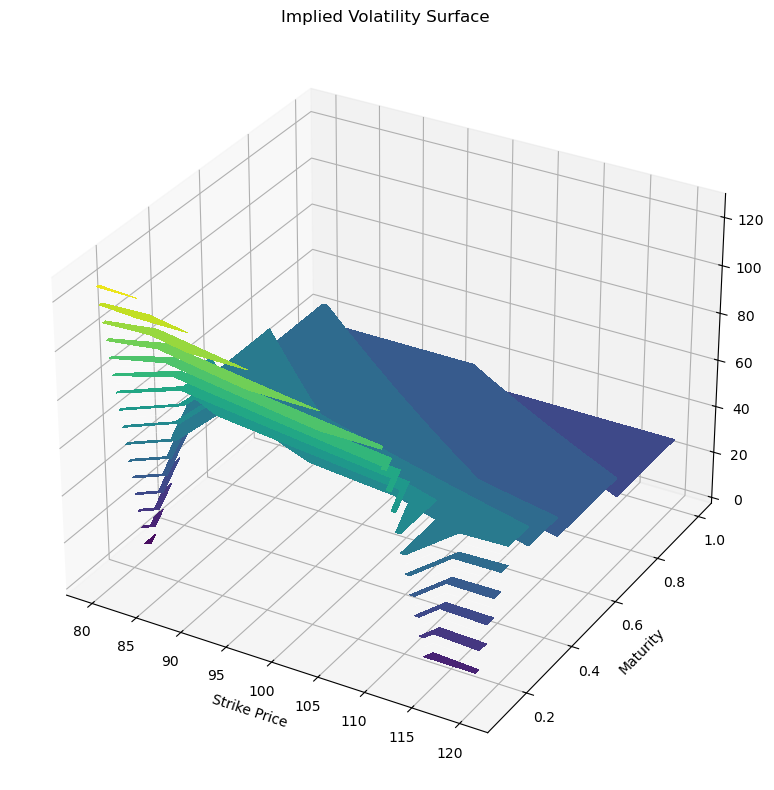

In [10]:
# --- 2. Run the Calculations ---

if __name__ == "__main__":
    """
    Demonstrate implied volatility extraction from Heston model
    """
    print("Heston Model: Implied Volatility Analysis")
    print("=" * 45)
    
    #S0, K, T, r, q = 100.0, 100.0, 0.25, 0.05, 0.02
    v0, theta, kappa, sigma, rho = [0.03, 0.03, 1.75, 0.25, -0.66]
    
    print(f"Parameters: S0=${S0}, r={r:.1%}, q={q:.1%}")
    print(f"Heston: v0={v0:.4f}, κ={kappa}, θ={theta:.4f}, σ={sigma}, ρ={rho}")
    
    # Single Option Implied Volatility
    print("Single Option Implied Volatility Example")
    print("-" * 42)
    
    # 1. Price option with Heston
    model_strikes, call_prices = price_call_heston_fft(S0, T, r,  v0, theta, kappa, sigma, rho)
    heston_call_price = np.interp(K, model_strikes, call_prices)
    heston_put_price = heston_call_price - S0 * np.exp(-q * T) + K * np.exp(-r * T)
    
    print(f"Heston Call Price: ${heston_call_price:.4f}")
    print(f"Heston Put Price:  ${heston_put_price:.4f}")
    
    # 2. Extract implied volatilities
    iv_call_nr = implied_volatility_newton_raphson(
        heston_call_price, S0, K, T, r, q, 'call'
    )
    iv_put_nr = implied_volatility_newton_raphson(
        heston_put_price, S0, K, T, r, q, 'put'
    )

    iv_call_bis = implied_volatility_bisection(
        heston_call_price, S0, K, T, r, q, 'call'
    )
    iv_put_bis = implied_volatility_bisection(
        heston_call_price, S0, K, T, r, q, 'put'
    )
    
    print(f"\nImplied Volatilities:")
    print(f"Call IV (Newton-Raphson): {iv_call_nr:.2%}")
    print(f"Put IV (Newton-Raphson):  {iv_put_nr:.2%}")
    print(f"Call IV (Bisection):      {iv_call_bis:.2%}")
    print(f"Put IV (Bisection):      {iv_put_bis:.2%}")
    print(f"True instantaneous vol:   {np.sqrt(v0):.2%}")
    print()
    
    # 3. Implied Volatility Surface
    print("Generating Implied Volatility Surface")
    print("-" * 40)
    
    # Reduced grid for demonstration
    strike_surface = np.linspace(80, 120, 9)
    time_surface = np.array([0.1, 0.25, 0.5, 1.0])
    
    iv_calls, iv_puts, prices_calls, prices_puts = heston_implied_volatility_surface(
        strike_surface, time_surface, S0, T, r, v0, theta, kappa, sigma, rho, method='newton_raphson'
    )
    
    print("\nImplied Volatility Surface (Calls):")
    print("Strike\\Time", end="")
    for t in time_surface:
        print(f"  {t:6.2f}y", end="")
    print()
    
    for i, k in enumerate(strike_surface):
        print(f"${k:6.1f}   ", end="")
        for j in range(len(time_surface)):
            print(f"  {iv_calls[j, i]:6.1%}", end="")
        print()
    
    print()
    
    # 4. Visualization
    print("Creating Visualization...")

    fig = plt.figure(figsize=(10, 8))   
    ax = fig.add_subplot(111, projection='3d')

    # Plot: IV Surface (3D)
    if len(strike_surface) > 1 and len(time_surface) > 1:
        X, Y = np.meshgrid(strike_surface, time_surface)
        contour = ax.contourf(X, Y, iv_calls * 100, levels=15, cmap='viridis')
        ax.contour(X, Y, iv_calls * 100, levels=15, colors='white', alpha=0.3, linewidths=0.5)
        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Maturity')
        ax.set_title('Implied Volatility Surface')

    plt.tight_layout()
    plt.show()


In [13]:
# --- Option Pricing via ADI ---

# --- 1. Model, Option, and Grid Parameters ---

# Heston model parameters
v0 = 0.04       # Initial variance
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance ('vol of vol')
rho = -0.6      # Correlation
# Option parameters
K = 100.0       # Strike price
T = 1.0         # Time to maturity (years)
r = 0.05        # Risk-free rate
S0 = 100.0      # Initial stock price
# Grid parameters
N_S = 200       # Number of stock price steps
N_v = 50        # Number of variance steps
N_t = 100       # Number of time steps
S_max = 2 * K   # Max stock price
v_max = 0.5     # Max variance

# --- 2. Define Pricing Function ---

def price_american_put_heston_hv_banded(params, option_params, grid_params):
    """
    Prices an American put using the stable Hundsdorfer-Verwer ADI scheme,
    solved efficiently with linalg.solve_banded
    """
    # Unpack parameters
    v0, theta, kappa, sigma, rho = params
    K, T, r, S0 = option_params
    N_S, N_v, N_t, S_max, v_max = grid_params

    # --- 2. Create Discretization Grids ---
    S_grid = np.linspace(0, S_max, N_S + 1)
    v_grid = np.linspace(0, v_max, N_v + 1)
    t_grid = np.linspace(0, T, N_t + 1)
    
    dS = S_grid[1] - S_grid[0]
    dv = v_grid[1] - v_grid[0]
    dt = t_grid[1] - t_grid[0]
    
    # Initialize grid for option values
    V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    
    # Set terminal condition (payoff at maturity)
    V = np.maximum(K - S_mat, 0)
    
    # --- 3. Backward Time Iteration Loop (Hundsdorfer-Verwer Scheme) ---
    theta_hv = 1 - (np.sqrt(2) / 2) # HV stability parameter
    
    for n in range(N_t, 0, -1):
        V_n = V.copy() # Solution at current time n

        # Apply boundary conditions
        V[0, :] = K * np.exp(-r * (T - t_grid[n-1]))
        V[-1, :] = 0
        V[:, 0] = V[:, 1]  # Neumann condition at v=0 (can be a source of instability if not careful)
        V[:, -1] = V[:, -2]

        # --- Stage 1: Explicit Predictor (Y0) ---
        LS_Vn, LV_Vn, LSV_Vn = np.zeros_like(V_n), np.zeros_like(V_n), np.zeros_like(V_n)

        # Calculate effect of operators L_S, L_v, L_sv on V_n
        # This approach builds the result vector directly without creating full matrices
        for i in range(1, N_S):
            for j in range(1, N_v):
                d2V_dS2 = (V_n[i+1, j] - 2*V_n[i, j] + V_n[i-1, j]) / dS**2
                dV_dS = (V_n[i+1, j] - V_n[i-1, j]) / (2*dS)
                LS_Vn[i, j] = 0.5*v_grid[j]*S_grid[i]**2*d2V_dS2 + r*S_grid[i]*dV_dS - r*V_n[i, j]

                d2V_dv2 = (V_n[i, j+1] - 2*V_n[i, j] + V_n[i, j-1]) / dv**2
                dV_dv = (V_n[i, j+1] - V_n[i, j-1]) / (2*dv)
                LV_Vn[i, j] = 0.5*sigma**2*v_grid[j]*d2V_dv2 + kappa*(theta-v_grid[j])*dV_dv
                
                d2V_dSdv = (V_n[i+1,j+1] - V_n[i-1,j+1] - V_n[i+1,j-1] + V_n[i-1,j-1]) / (4*dS*dv)
                LSV_Vn[i, j] = rho*sigma*v_grid[j]*S_grid[i]*d2V_dSdv

        Y0 = V_n + dt * (LS_Vn + LV_Vn + LSV_Vn)
        
        # --- Stage 2: Implicit S-Correction (Y1) ---
        Y1 = Y0.copy()
        for j in range(1, N_v):
            vj = v_grid[j]
            alpha_S = 0.5*vj*S_grid[1:-1]**2/dS**2 - r*S_grid[1:-1]/(2*dS)
            beta_S = -vj*S_grid[1:-1]**2/dS**2 - r
            gamma_S = 0.5*vj*S_grid[1:-1]**2/dS**2 + r*S_grid[1:-1]/(2*dS)
            
            # LHS Matrix (I - theta*dt*L_S) in banded format
            ab_S = np.zeros((3, N_S - 1))
            ab_S[0, 1:] = -theta_hv * dt * gamma_S[:-1]
            ab_S[1, :] = 1 - theta_hv * dt * beta_S
            ab_S[2, :-1] = -theta_hv * dt * alpha_S[1:]

            # RHS Vector
            RHS_S = Y0[1:-1, j] - theta_hv * dt * LS_Vn[1:-1, j]
            Y1[1:-1, j] = linalg.solve_banded((1, 1), ab_S, RHS_S)

        # --- Stage 3: Implicit V-Correction (V_next) ---
        V_next = Y1.copy()
        for i in range(1, N_S):
            Si = S_grid[i]
            alpha_v = 0.5*sigma**2*v_grid[1:-1]/dv**2 - kappa*(theta-v_grid[1:-1])/(2*dv)
            beta_v = -sigma**2*v_grid[1:-1]/dv**2
            gamma_v = 0.5*sigma**2*v_grid[1:-1]/dv**2 + kappa*(theta-v_grid[1:-1])/(2*dv)
            
            # LHS Matrix (I - theta*dt*L_v) in banded format
            ab_v = np.zeros((3, N_v - 1))
            ab_v[0, 1:] = -theta_hv * dt * gamma_v[:-1]
            ab_v[1, :] = 1 - theta_hv * dt * beta_v
            ab_v[2, :-1] = -theta_hv * dt * alpha_v[1:]
            
            # RHS Vector
            RHS_v = Y1[i, 1:-1] - theta_hv * dt * LV_Vn[i, 1:-1]
            V_next[i, 1:-1] = linalg.solve_banded((1, 1), ab_v, RHS_v)

        # --- 4. Enforce American Early Exercise ---
        payoff = np.maximum(K - S_mat, 0)
        V = np.maximum(V_next, payoff)

    # --- 5. Interpolate to find price at (S0, v0) ---
    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V


--- Heston American Put Price (HV Scheme with solve_banded) ---
Grid Size (S x v x t): 200 x 50 x 100
Option Price at S0=100.0, v0=0.04: -0.0000



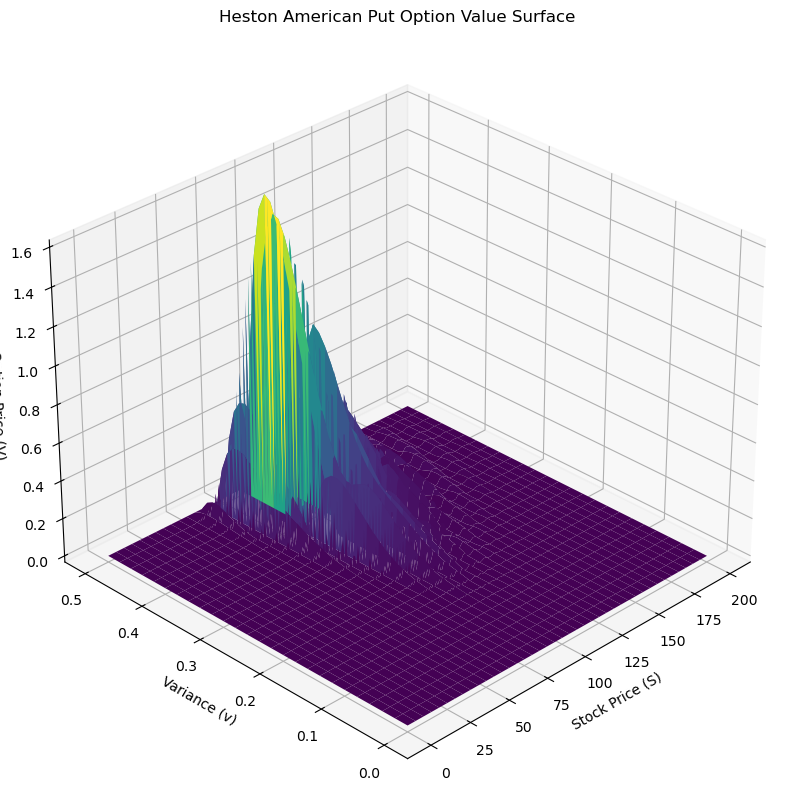

In [14]:
# --- 3. Execute Optimization Function ---

if __name__ == '__main__':
    # Pack parameters into tuples
    model_params = (v0, theta, kappa, sigma, rho)
    option_params = (K, T, r, S0)
    grid_params = (N_S, N_v, N_t, S_max, v_max)

    S_grid = np.linspace(0, S_max, N_S + 1)
    v_grid = np.linspace(0, v_max, N_v + 1)

    # Calculate the price
    price, V_surface = price_american_put_heston_hv_banded(model_params, option_params, grid_params)
    
    print("--- Heston American Put Price (HV Scheme with solve_banded) ---")
    print(f"Grid Size (S x v x t): {N_S} x {N_v} x {N_t}")
    print(f"Option Price at S0={S0}, v0={v0}: {price:.4f}\n")
    
    # --- 7. Plotting ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_surface, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price (V)")
    ax.view_init(30, -135) # Adjust viewing angle
    plt.show()

Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.6, r=0.05, T=1.0

Grid Size: 200 (Stock Price) x 50 (Variance) x 100 (Time)
Price for an at-the-money (S0=100.0, K=100.0) American Put Option: 0.0000


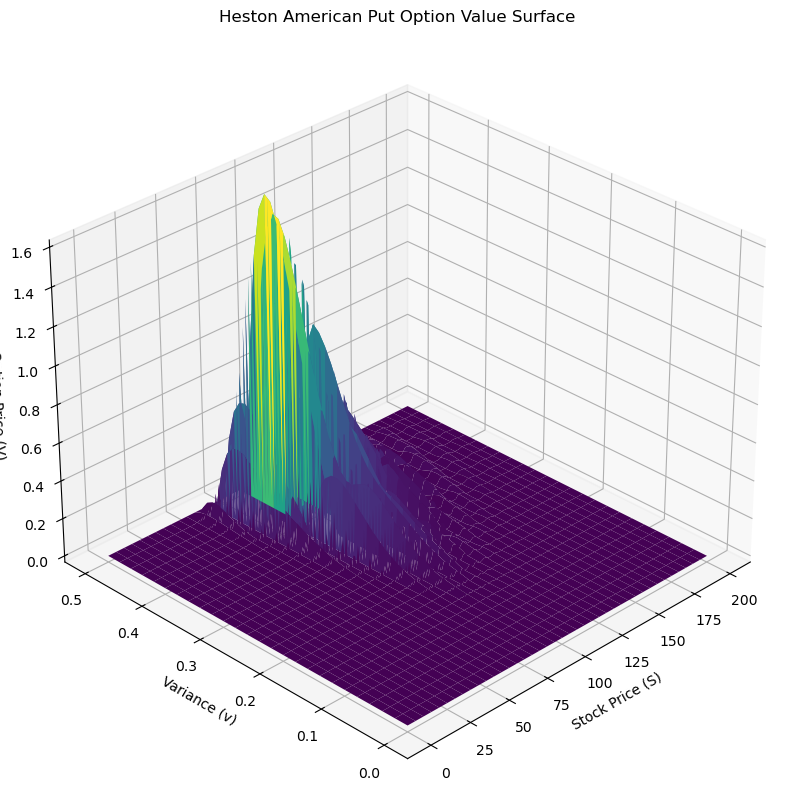

In [15]:
# --- Option Pricing via ADI using spsolve instead of solve_banded ---

# --- 1. Grid Parameters ---

S_grid = np.linspace(0, S_max, N_S + 1)
v_grid = np.linspace(0, v_max, N_v + 1)
t_grid = np.linspace(0, T, N_t + 1)

dS = S_grid[1] - S_grid[0]
dv = v_grid[1] - v_grid[0]
dt = t_grid[1] - t_grid[0]

# --- 2. Define Main Pricing Function using spsolve ---

def price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                      S_grid, v_grid, t_grid):
    """
    Prices an American put option using the Heston model,
    solving the linear systems with scipy.sparse.linalg.spsolve.
    """
    N_S = len(S_grid) - 1
    N_v = len(v_grid) - 1
    N_t = len(t_grid) - 1
    
    V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        Y = np.zeros_like(V)
        
        for j in range(1, N_v):
            vj = v_grid[j]
            
            alpha_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / dS)
            beta_S = -0.5 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r)
            gamma_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / dS)
            
            # --- Create A_S as a sparse matrix using diags ---
            diagonals_S = [-alpha_S[1:], 1 - beta_S, -gamma_S[:-1]]
            offsets = [-1, 0, 1]
            A_S_sparse = diags(diagonals_S, offsets, shape=(N_S - 1, N_S - 1), format='csc')
            
            # Setup RHS (Right-Hand Side)
            B_S_V = (V[1:-1, j] + 
                     alpha_S * V[:-2, j] + 
                     beta_S * V[1:-1, j] + 
                     gamma_S * V[2:, j])

            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            rhs = B_S_V + dt * L_v_V

            rhs[0] += 2 * alpha_S[0] * K 
            rhs[-1] += 2 * gamma_S[-1] * 0
            
            # Solve using spsolve
            Y[1:-1, j] = spsolve(A_S_sparse, rhs)

        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1]))
        Y[:, -1] = Y[:, -2]
        
        # -- Final Step (V) --
        for i in range(1, N_S):
            Si = S_grid[i]
            
            alpha_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / dv)
            beta_v = -0.5 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            gamma_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / dv)

            # --- Create A_v as a sparse matrix using diags ---
            diagonals_v = [-alpha_v[1:], 1 - beta_v, -gamma_v[:-1]]
            offsets_v = [-1, 0, 1]
            A_v_sparse = diags(diagonals_v, offsets_v, shape=(N_v - 1, N_v - 1), format='csc')

            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            L_S_V = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * V[i, 1:-1]
            L_S_Y = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * Y[i, 1:-1]
            
            # B_v_V is the explicit part for the v-direction
            B_v_V = V[i, 1:-1] + alpha_v*V[i, :-2] + beta_v*V[i, 1:-1] + gamma_v*V[i, 2:]
            
            rhs_v = B_v_V + (L_S_Y - L_S_V)
            
            rhs_v[0] += 2 * alpha_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            
            # Solve using spsolve
            V[i, 1:-1] = spsolve(A_v_sparse, rhs_v)
            
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V

# --- 3. Price the option and visualize the results ---

if __name__ == '__main__':
    price, V_grid = price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                                      S_grid, v_grid, t_grid)
    
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Grid Size: {N_S} (Stock Price) x {N_v} (Variance) x {N_t} (Time)")
    print(f"Price for an at-the-money (S0={S0}, K={K}) American Put Option: {price:.4f}")

    # --- 7. Plotting ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_surface, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price (V)")
    ax.view_init(30, -135) # Adjust viewing angle
    plt.show()
